# Install / Import

In [19]:
!pip install import_ipynb
import import_ipynb

In [20]:
import matplotlib as mpl

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.ndimage as nd

from scipy.sparse import identity

from google.colab import drive
drive.mount('/content/gdrive')
import sys

path_to_module = '/content/gdrive/MyDrive/ColabNotebooks/PC_param.ipynb'
sys.path.append(path_to_module)

#import gdrive.MyDrive.ColabNotebooks.PC_param # .default_parameters_network

from gdrive.MyDrive.ColabNotebooks.PC_param import default_parameters_network

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Functions

In [21]:

# //////////////  FUNCTIONS ////////////////////////////////////////

# 1- Input/Output function
def phi(I_tot, a, b, hm):
    return hm * (1 / (1 + np.exp(- (a * I_tot + b))))

def phiwongE(I_tot, c = 310, g=.16, Ie= 125):
    return (c * I_tot - Ie) / 1 - np.exp(-g * (c *I_tot - Ie))
def phiwongI(I_tot, c = 615, g =.16, Ii = 125):
    return (c * I_tot - Ii) / 1 - np.exp(-g * (c *I_tot - Ii))



# 2- Input/Output function
def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))#, param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
      plt.xlim(xlim_ar) #[0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()

def plot_s(range_sim, S_e, S_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei)) #, param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)
    if xlim_ar != None:
      plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    #plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()

# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)

    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# 3- Compute derivative

def wilsonCowanWong(p1: classmethod, p2: classmethod, sim: classmethod, param: classmethod, k: object, stim: classmethod) -> object:
    dt = sim.dt
    s_ampa, r_e, i_tot_e, dr_e_dt, phi_arr_e = p1.S, p1.r, p1.Itot, p1.drdt, p1.Phi
    s_gaba, r_i, i_tot_i, dr_i_dt, phi_arr_i = p2.S, p2.r, p2.Itot, p2.drdt, p2.Phi
    In = stim.In #, range_sim, w, sigmaIn =stim.sensoryInput(param, sim)
    #I_noise_E = np.random.normal(0, .0007, 1)
    #I_noise_I = np.random.normal(0, .0007, 1)

    i_tot_e[k, :] = param.Jee * s_ampa[k - 1, :] - param.Jie * np.dot(s_gaba[k - 1, :], param.wie) + param.Jin * In[k-1,:]
    i_tot_i[k, :] = param.Jei * np.dot(s_ampa[k - 1, :], param.wei) - param.Jii * np.dot(s_gaba[k - 1, :], param.wii)

    phi_arr_e = phi(i_tot_e[k, :], param.ae, param.be, param.hme) #phiwongE(i_tot_e[k])#
    phi_arr_i = phi(i_tot_i[k, :], param.ai, param.bi, param.hmi) #phiwongI(i_tot_i[k])#

    dr_e_dt[k, :] = (-r_e[k - 1, :] + phi_arr_e) / param.taue
    dr_i_dt[k, :] = (-r_i[k - 1, :] + phi_arr_i) / param.taui

    r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :] * dt
    r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :] * dt

    dS_amp_dt = (- s_ampa[k - 1, :] / param.tauAMPA) + r_e[k, :]
    s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * dt


    dS_gab_dt = (- s_gaba[k - 1, :] / param.tauGABA) + r_i[k, :]
    s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * dt

    return r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In



# Filters: Gauss,  Dog and LoG

def gaussian_filter(s, N): #normalisation not needed when sigma <.4
    k = np.arange(1, N+1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis])**2 / (2 * s**2))
    #gaussW = n * np.exp(-(k - k[:, np.newaxis])**2 / (2 * s**2))
    #normG = (gaussW.T / gaussW.sum(axis = 0)).T   #gaussW = gaussW / np.sum(gaussW)  #(0.01**2 / np.max(gaussW))
    return gaussW #normG


def dog_filter(sIn, sOut, N):
    k = np.arange(1, N+1)
    gaussIn =  np.exp(-(k - k[:, np.newaxis])**2 / (2 * sIn**2))
    gaussOut = np.exp(-(k - k[:, np.newaxis])**2 / (2 * sOut**2))
    dog = gaussOut - gaussIn
    sumDoG = dog.sum(axis = 1)   #sum over each row
    dog = (dog.T / sumDoG).T  # elementwise division # dog/np.sum(dog)   # / (0.88**2 / np.max(dog))
    return dog

def LoG_filter(s, N):
  x_lap = np.eye(N)
  lapl_filter = nd.gaussian_laplace(x_lap , sigma= (s, s))
  return lapl_filter

def dLogGaus(s =.61, N=20):
  dig = LoG_filter(s, N) + gaussian_filter(.019 *s, N)
  return dig

In [22]:
np.arange(1, 21).shape
np.eye(21).shape

(21, 21)

# Class

In [23]:
pars = default_parameters_network()

In [24]:
# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise, Jee = pars['be'], pars['hme'], pars['I_noise'], pars['Jee']
    taui, ai, bi, hmi, Jii, Jei, Jie = pars['taui'], pars['ai'], pars['bi'], pars['hmi'], pars['Jii'], pars['Jei'], \
                                       pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq = pars['Jiq']  #0.85; #nA
    Jin = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma = pars['gamma']  # nmda coupling parameter from brunel
    # I1, I2 = pars['I1'], pars['I2']
    c_dash = pars['c_dash']
    sigma = pars['sigma']  #param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)

    sigmaIn = pars['sigmaIn']

    #Input parameters
    In0 = pars['In0']       #% Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']   #% Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']       #% Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']   #% Max firing rate of feedback populations (Hz)

    #Gaussian filter

    #sIn = pars['sigmaInh'][0]
    #sOut = pars['sigmaInh'][1]


    def __init__(self,sEI, sIn, sOut, N=20): # sEI=4, sIn=.2, sOut=1.2,
      # Weights (from gaussian filter)
      self.N = N  #pars['NumN']
      self.wei = dLogGaus(s =.61, N=20) #LoG_filter(s=.6, N= 20) # dLogGaus(s =.61, N=20) #LoG_filter(s=.6, N= 20) #dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
      self.wie = gaussian_filter(sEI, N) #dog_filter(sIn, sOut, N)
      self.wii = np.eye(N)#dog_filter(sIn, sOut, N)#np.eye(N) #
      self.wes = np.eye(N) # Identity matrix
      self.f = np.arange(1, N +1)
      self.sEI = sEI
      self.sIn = sIn
      self.sOut = sOut




    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())




# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = np.arange(0, self.T, self.dt)
        self.Lt = self.range_t.size


    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°
class Neurons:
    def __init__(neur, Ltime, Ntime , RFfrequency =0, init_r=0, init_S=0 ):
        neur.r = np.zeros((Ltime, Ntime), dtype='float64')
        neur.drdt = np.zeros((Ltime, Ntime), dtype='float64')
        neur.S = np.zeros((Ltime,Ntime), dtype='float64')
        neur.Itot =np.zeros((Ltime, Ntime), dtype='float64')
        neur.Phi = np.zeros((Ltime, Ntime)) #np.zeros(Ltime)
        neur.rinit = init_r
        neur.Sinit = init_S
        neur.RFf = RFfrequency
        if neur.Sinit != 0:
          neur.S[0,:] = neur.Sinit
         # neur.S = np.full((Ltime, Ntime), neur.Sinit)



    def printNeur(neur):
        print("size S and r andItot and Phi is: ", neur.S.shape, neur.r.shape, neur.Itot.shape, neur.Phi.shape)



class Stim:
  def __init__(self, param, simu, f=[10], ISI = 1, dur = 0.2): #8
    self.f = f #array of frequency stimulus types
    self.ISI = ISI # inter-stimulus interval
    self.dur = dur #duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
    self.tail   = 0;
    self.predDt = 0;
    self.pred   = 0;
    self.InMax = param.InMax
    self.In0 = param.In0

    # Instantaneous frequency
    f_instant = np.zeros((int(self.ISI / simu.dt)+1, 1)) #size ISI : 1 /dt : 1000

    #print(f.shape)
    for fx in self.f:
      fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx, #just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                               np.zeros((int(self.ISI / simu.dt), 1))))   # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    f_stim = np.vstack((f_instant, fx_array)) #stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
    self.f_stim = f_stim[1:] #1400*1

  #bottom up sensory Input # duration 1sec # sigmaIn 2
  def sensoryInput(self, parameter, simu,sigmaIn = 2, paramf = None , f_stim = None, InMax = None, In0 = None):
      #paramf = np.arange(1, 101)
      w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

      #totalAct = w.sum(axis = 1) #sum over each row
      #norm_w = (w.T / totalAct).T # elementwise division
      In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0), 0) #if stim >0 give InMax * weight + In0 otherwise give 0
      if self.tail != 0:
        tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
        In = np.hstack((In, tail_zeros))

      range_sim = np.arange(1, In.shape[0] +1)
      self.In = In
      self.w = w
      self.sigmaIn = sigmaIn
      return In, range_sim, w, sigmaIn
  def printStim(self):
    print("frequence of stimulus f:", self.f, "  ISI:",self.ISI, " Size In:", self.In.shape, "Size w:", self.w.shape, "  f_stim:", self.f_stim.shape,
          "sigmaIn:", self.sigmaIn)



# Initiate the Classes and run the function

In [25]:

## Call the classes, Parametter setting and run
def parameterSetting(Jee = 0.0081, Jei=.87, Jie= .1, Jin=.00989, Jii=.00081): #, sIn = .1, sOut =3.5, sEI = .1):
  N=20
  #1.99
  #param = Parameter(N = 20, sIn = .61, sOut =3., sEI = .2)#sIn =.1, sOut =7.6, sEI = .2) #1.2, sOut =3.4, sEI = 1.2

  param = Parameter(N = 20, sIn = .06, sOut =3., sEI = .2)#sIn =.1, sOut =7.6, sEI = .2) #1.2, sOut =3.4, sEI = 1.2

  #param = Parameter(N = 20, sIn = .1, sOut =3., sEI = .2)#sIn =.1, sOut =7.6, sEI = .2) #1.2, sOut =3.4, sEI = 1.2

  #param = Parameter(N = 20, sIn = .1, sOut =3.5, sEI = .19)#sIn =.1, sOut =7.6, sEI = .2) #1.2, sOut =3.4, sEI = 1.2
  #param = Parameter(N = 20, sIn = .1, sOut =5.4, sEI = .2) #10.5 SEI=.2good without sIn = .1, sOut =16.5 sEI=.5  #without testicles: sIn=.1 sOut=8.5  # with testicle: sIn = .1, sOut =1.5
  #param = Parameter(N = 20, sIn = .1, sOut =3.4, sEI =.2) #10.5 SEI=.2good without sIn = .1, sOut =16.5 sEI=.5  #without testicles: sIn=.1 sOut=8.5  # with testicle: sIn = .1, sOut =1.5
  J =[Jin, Jee, Jie, Jei, Jii]
  #sigmas = [sIn, sOut, sEI]
  sigmas = [param.sIn, param.sOut, param.sEI]# = sigmas
  param.Jin, param.Jee, param.Jie, param.Jei, param.Jii = J
  #param.sIn, param.sOut, param.sEI = sigmas
  print("sIN", sigmas[0], "sout", sigmas[1], "sEI", sigmas[2])
  #print(param.wei.shape)
  print("Jee:", param.Jee, "  Jei:", param.Jei)
  print("Jii", param.Jii, "Jie:", param.Jie, " Jin:", param.Jin)

  # \\\\\\\\\\\ Simulation time
  simu = Simulation(1e-4, .4) #dt #rangeSim #dur = 2s
  simu.printSim()

  # \\\\\\\\\\\ Bottom up sensory input
  stim = Stim(param,simu, dur=.3, ISI=.05) #dur = 1s Isi=1s
  #print(param.f.shape)
  In, range_sim, w, sigmaIn =stim.sensoryInput(param, simu)
  #stim.printStim()

  # \\\\\\\\\\\ Neurons (empty variables)
  pop3 = Neurons(In.shape[0], param.N)#
  pop4 = Neurons(In.shape[0], param.N)


  # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  for i in range(1, In.shape[0]):
      r_E, r_I, S_ampa, S_gaba, I_tot_E, I_tot_I, In = wilsonCowanWong(pop3, pop4, simu, param, i, stim)

  return r_E, r_I, J, S_ampa, S_gaba,I_tot_E,I_tot_I, In, range_sim, w,param, sigmaIn


# Call everything

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0081   Jei: 0.65
Jii 0.00081 Jie: 0.15  Jin: 0.00989
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


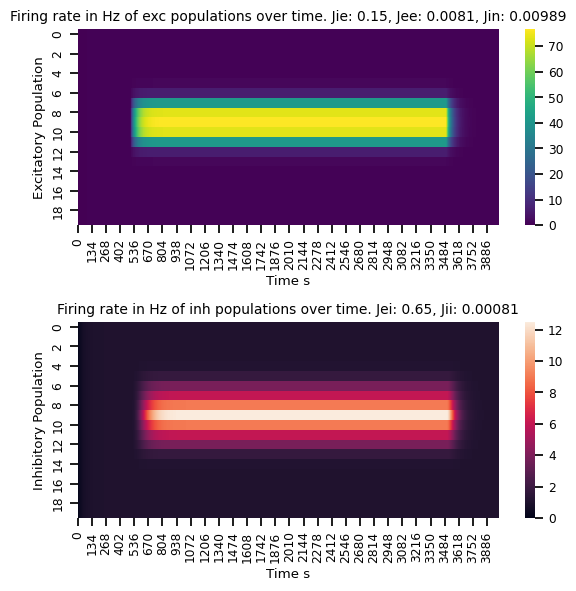

In [26]:

#here try to adjust for the firing rate while keeping the nice peak: #Jei below 1 and still good peak
#r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param = parameterSetting(Jee = 0.071, Jei=.7, Jie= .1, Jin=.0075, Jii=.03) #good #.91

#really not bad 50hz no testicle
#r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param = parameterSetting(Jee = 0.071, Jei=.7, Jie= .1, Jin=.0078, Jii=.08) #good #.91
#
#The good one:
#r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1 = parameterSetting(Jee = 0.0081, Jei=.87, Jie= .1, Jin=.00989, Jii=.00081) #good #.91
#r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1 = parameterSetting(Jee = 0.0081, Jei=.57, Jie= .1, Jin=.00989, Jii=.00081) #good #.91
r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1, sigmaIn = parameterSetting(Jee = 0.0081, Jei=.65, Jie= .15, Jin=.00989, Jii=.00081) #good #.91
#r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1 = parameterSetting(Jee = 0.0081, Jei=.28, Jie= .061, Jin=.010989, Jii=.00081) #good #.91




#try Jee 0.1
HeatMap(r_E, r_I, J)

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.28
Jii 0.0001 Jie: 0.001  Jin: 0.0077
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


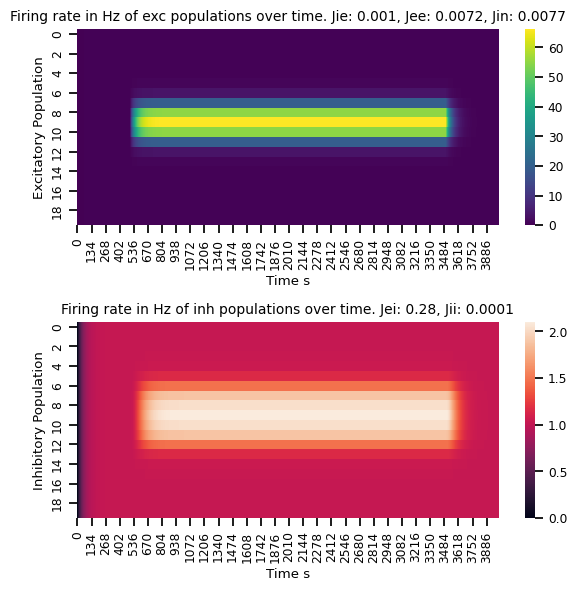

In [27]:
#no oscillation , good but not lateral inhibition
#r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1 = parameterSetting(Jee = 0.0061, Jei=.32, Jie= .001, Jin=.0075, Jii=.00001) #good #.91

#
r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1, sigmaIn = parameterSetting(Jee = 0.0072, Jei=.28, Jie= .001, Jin=.0077, Jii=.0001) #good #.91

HeatMap(r_E, r_I, J)

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.001 Jie: 0.61  Jin: 0.0073
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


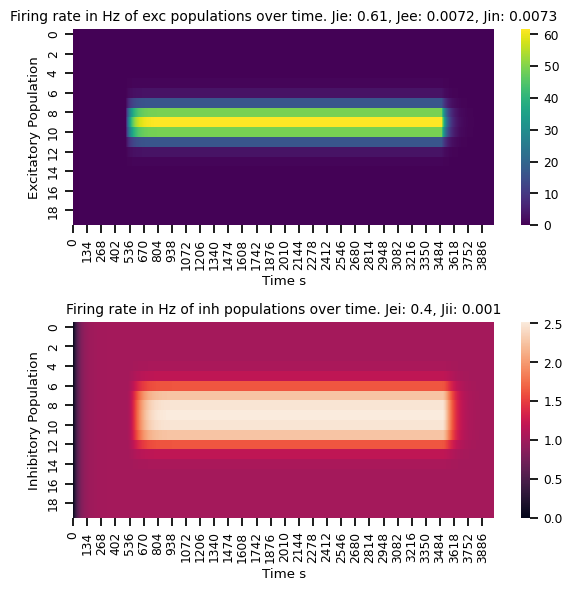

In [28]:
r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1, sigmaIn = parameterSetting(Jee = 0.0072, Jei=.4, Jie= .61, Jin=.0073, Jii=.001) #good #.91

HeatMap(r_E, r_I, J)

# Plot Firing rate across pop for time t

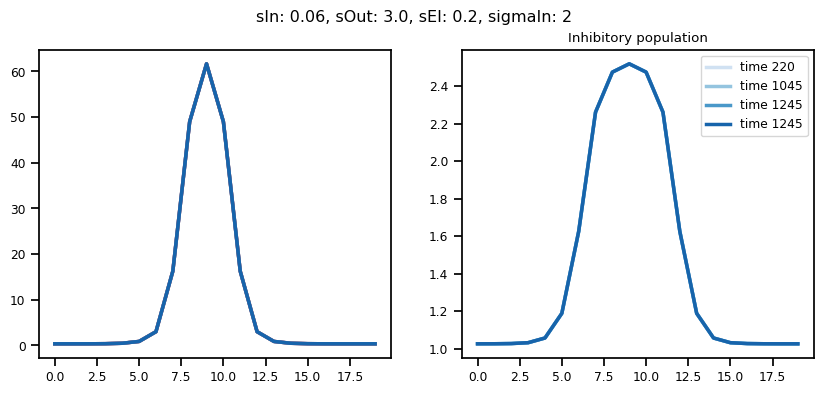

In [29]:
pop = np.arange(0, 20)
#sns.color_palette("mako")#, as_cmap=True)
#sns.set_palette("Blues",n_colors=4)
sns.set_palette("Blues", n_colors=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4))
"""
ax1.plot(pop, r_E[220,:], label = "time 220")
ax1.plot(pop, r_E[235,:], label = "time 235")
ax1.plot(pop, r_E[350,:], label = "time 350")
ax1.plot(pop, r_E[374,:], label = "time 374")
#ax1.plot(pop, r_E[586,:], label = "time 186")

ax1.set_title("Exitatory population")
"""
ax1.plot(pop, r_E[1045,:], label = "time 1045")
ax1.plot(pop, r_E[1202,:], label = "time 1245")

ax1.plot(pop, r_E[2220,:], "r",label = "time 1245")
ax1.plot(pop, r_E[1202,:], label = "time 1245")
ax1.plot(pop, r_E[2302,:], label = "time 13000")


ax2.plot(pop, r_I[2200,:], label = "time 220")
"""
ax2.plot(pop, r_I[235,:], label = "time 235")
ax2.plot(pop, r_I[350,:], label = "time 350")
ax2.plot(pop, r_I[374,:], label = "time 374")

#ax2.plot(pop, r_I[500,:], label = "time 500")
#ax2.plot(pop, r_I[586,:], label = "time 186")
"""
ax2.plot(pop, r_I[1045,:], label = "time 1045")
ax2.plot(pop, r_I[1202,:], label = "time 1245")
ax2.plot(pop, r_I[2202,:], label = "time 1245")
"""
#ax2.plot(pop, r_I[222,:], "r",label = "time 1245")

#ax2.plot(pop, r_I[1302,:], label = "time 13000")

"""
ax2.set_title("Inhibitory population")
fig.suptitle(f"sIn: {param1.sIn}, sOut: {param1.sOut}, sEI: {param1.sEI}, sigmaIn: {sigmaIn}")

plt.legend()
plt.show()

# Plot  S

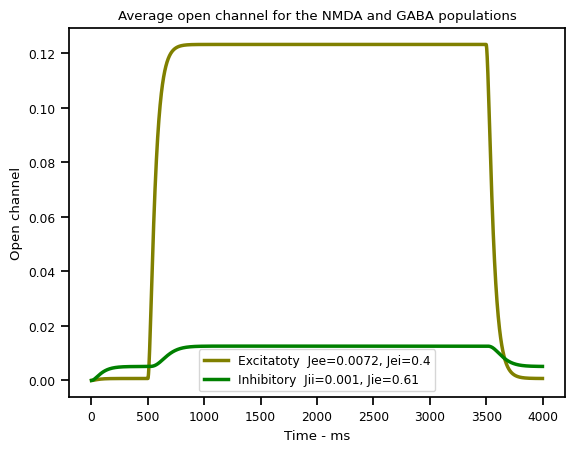

In [30]:
plot_s(range_sim, S_ampa[:,9], S_gaba[:,9], param1)

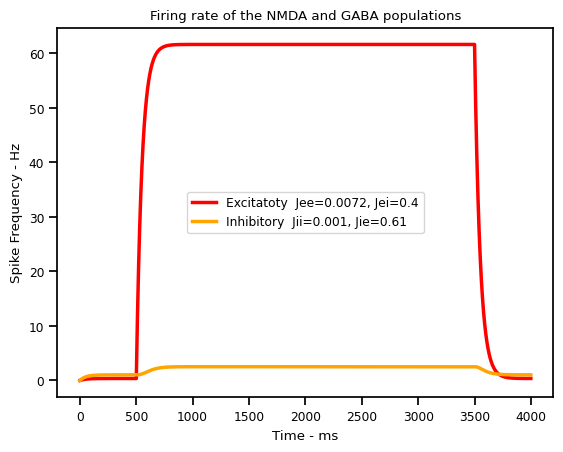

In [31]:
"""fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(np.arange(0, 1400), r_E[:,9], "r",label = "AMPA")
ax1.plot(np.arange(0, 1400), r_I[:,9], "orange",label = "GABA")
ax1.set_title(f"param:{param1.Jee}")
ax2.plot(np.arange(0, 1400), r_E[:,10], "r",label = "AMPA")
ax2.plot(np.arange(0, 1400), r_I[:,10], "orange",label = "GABA")
"""
#, r_I[:,10], param1)
#plot_r(range_sim, r_E[:,9], r_I[:,7], param1)
plot_r(range_sim, r_E[:,9], r_I[:,9], param1)

# influence of Jee and Jii on the firing rate and the gating variable

### firing rate

In [32]:
#r_E, r_I, J, S_ampa, S_gaba, I_tot_E, I_tot_I, In, range_sim, w, param1 =
#parameterSetting(Jee = 0.0081, Jei=.87, Jie= .1, Jin=.00989, Jii=.00081) #good #.91

# Jei=.87, Jie= .1,

In [33]:
J_E = np.linspace(.47,.87,20)
J_E

array([0.47      , 0.49105263, 0.51210526, 0.53315789, 0.55421053,
       0.57526316, 0.59631579, 0.61736842, 0.63842105, 0.65947368,
       0.68052632, 0.70157895, 0.72263158, 0.74368421, 0.76473684,
       0.78578947, 0.80684211, 0.82789474, 0.84894737, 0.87      ])

In [34]:
def Jset(j, R, incr):
  X =[]

  if j == "Jei":
      # High Js =#X = parameterSetting(Jee = 0.0081, Jei= incr, Jie= .15, Jin=.00989, Jii=.00081) # High Js =#
      #X = parameterSetting(Jee = 0.0072, Jei=incr, Jie= .001, Jin=.0069500000000000004, Jii=.0001) #Low Js

      #after Norm
      X = parameterSetting(Jee = 0.0072, Jei = incr, Jie= .001, Jin=0.0069500000000000004, Jii=.01) #Low Js #Jei=.28

      #LoG
      X = parameterSetting(Jee = 0.0072, Jei = incr, Jie= .001, Jin=0.0069500000000000004, Jii=.01) #Low Js #Jei=.28
      #HeatMap(X[0], X[1], X[2])
      #rE = X[index]

  elif j == "Jie":
      # High Js =# X = parameterSetting(Jee = 0.0081, Jei=.87, Jie= incr, Jin=.00989, Jii=.00081)
      #X = parameterSetting(Jee = 0.0072, Jei = .4, Jie= incr, Jin=0.0069500000000000004, Jii=.0001) #Low Js #Jei=.28
      #X = parameterSetting(Jee = 0.0072, Jei = .9, Jie= incr, Jin=0.0069500000000000004, Jii=.0001) #Low Js #Jei=.28

      #after norm
      X = parameterSetting(Jee = 0.0072, Jei = .4, Jie= incr, Jin=0.0069500000000000004, Jii=.01) #Low Js #Jei=.28

      #LoG
      X = parameterSetting(Jee = 0.0072, Jei = .4, Jie= incr, Jin=0.0069500000000000004, Jii=.01) #Low Js #Jei=.28

      #rE = X[index]
  elif j == "Jin":
      # High Js =#X = parameterSetting(Jee = 0.0081, Jei=.65, Jie= .15, Jin=incr, Jii=.00081)
      #X = parameterSetting(Jee = 0.0072, Jei=.9, Jie= .001, Jin=incr, Jii=.0001) #Low Js  #Jei=.28

      X = parameterSetting(Jee = 0.0072, Jei = 4.54, Jie= 0.001, Jin=incr, Jii=.01) #Low Js #Jei=.28


      #LoG
      X = parameterSetting(Jee = 0.0072, Jei = 4.54, Jie= incr, Jin=0.0069500000000000004, Jii=.01) #Low Js #Jei=.28


  rI = X[1]
  rE = X[0]
  return HeatMap(X[0], X[1], X[2]) #plot_r(X[8], rE[:,9], rI[:,9], X[10])

def R_Jsetting(j):
  R = [] #np.zeros(20)
  J_EI = np.linspace(.2,1,5)#J_EI = np.linspace(.4,.7,10)#(.65,.75,5) # low Jei .28
  #J_IE = np.linspace(.001,.11,5) # # low Jei  .001
  J_IE = np.linspace(0.01,1,5) # # low Jei  .001
  J_In = np.linspace(.006,.008,5) ## low Jei  Jin=.0077 # 0.00695 good


  if j == "Jei":
    for incre in J_EI:
        Jset("Jei", R, incre)
  elif j == "Jie":
    for incre in J_IE:
        Jset("Jie", R, incre)
  elif j == "Jin":
    for incre in J_In:
        Jset("Jin", R, incre)



#R_Jsetting("Jei")
#R_Jsetting("Jie")



sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.2
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.2
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


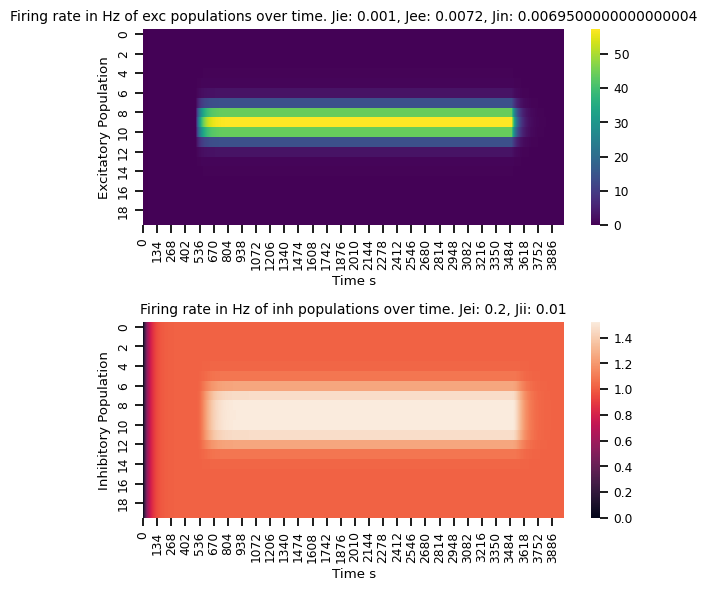

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


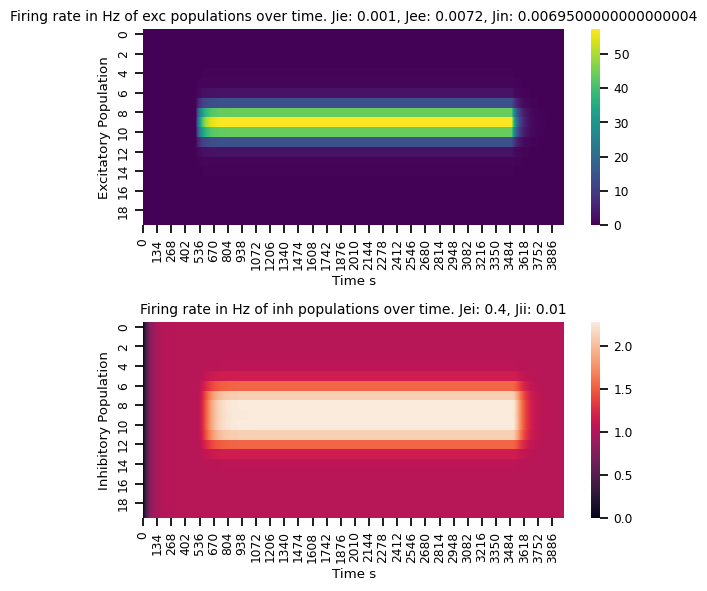

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.6000000000000001
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.6000000000000001
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


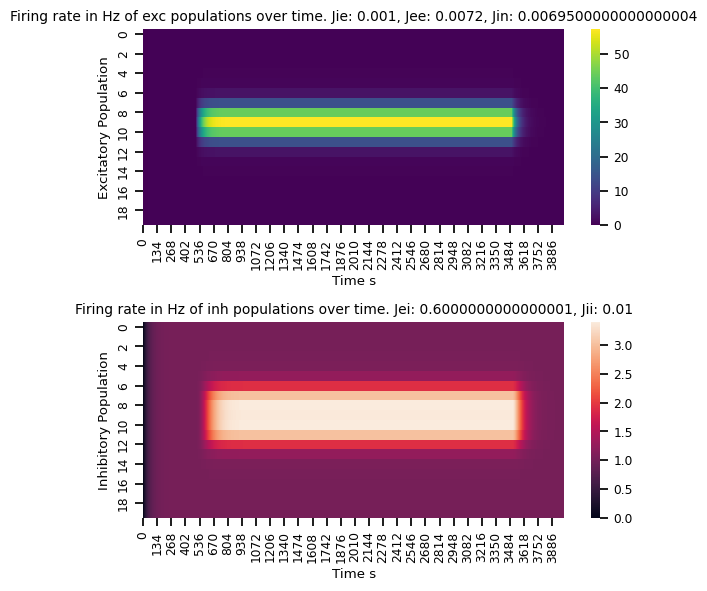

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.8
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.8
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


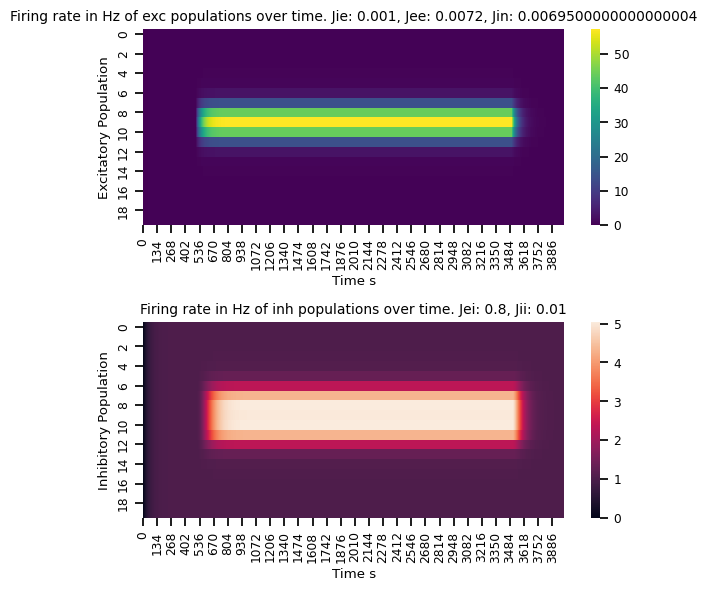

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 1.0
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 1.0
Jii 0.01 Jie: 0.001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


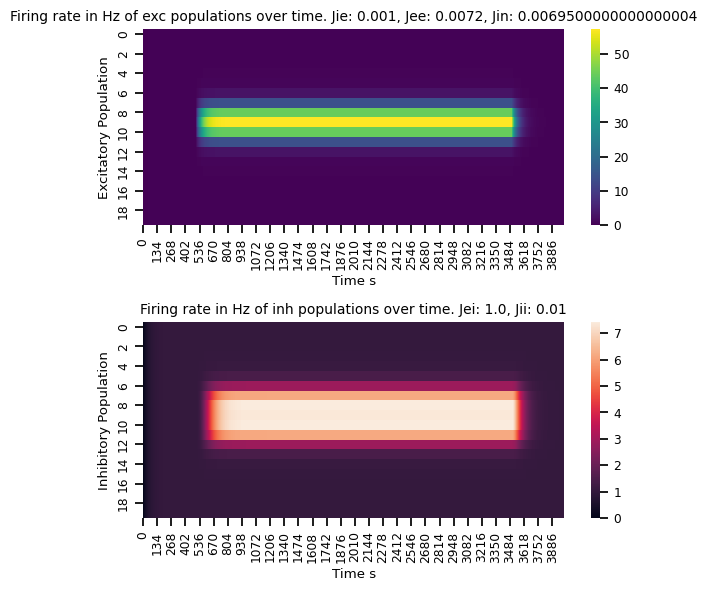

In [35]:
R_Jsetting("Jei")

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.01  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.01  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


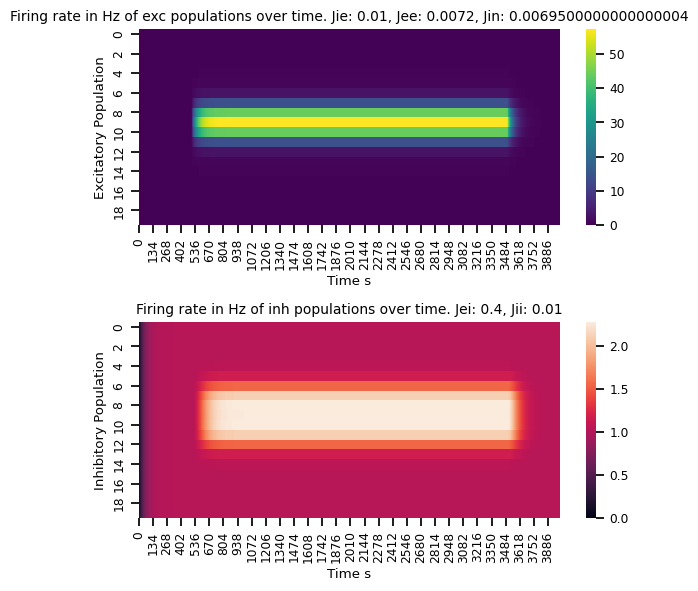

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.2575  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.2575  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


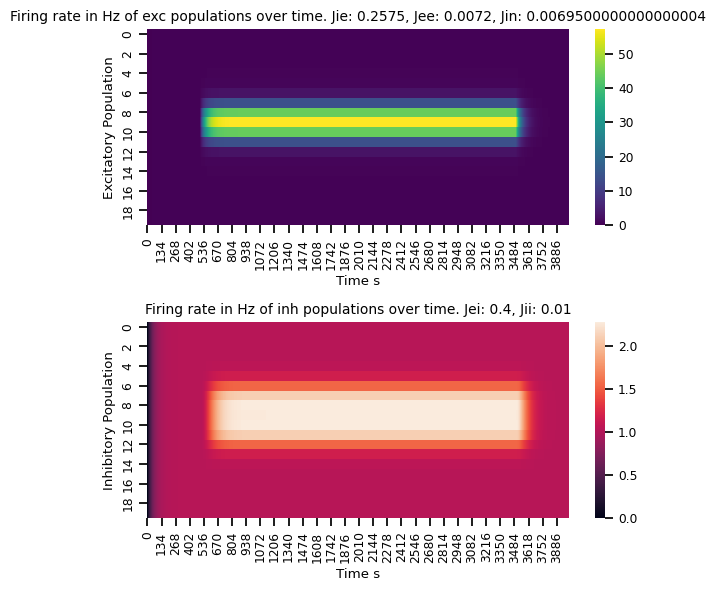

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.505  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.505  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


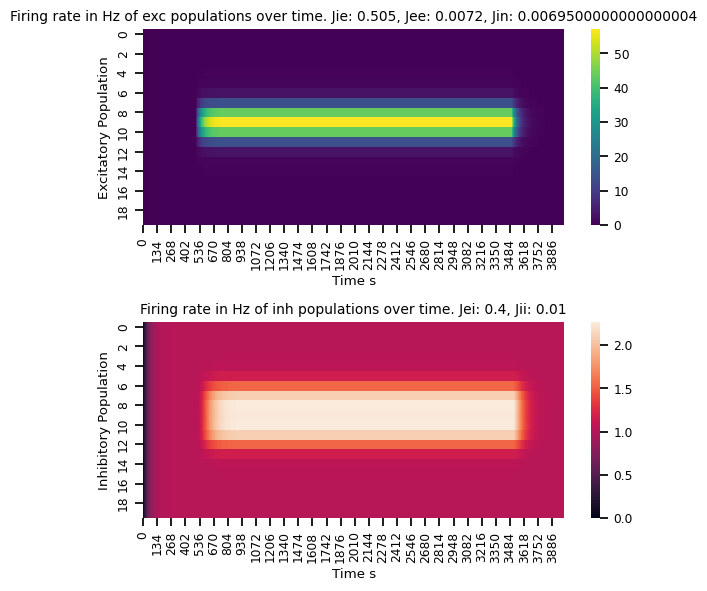

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.7525  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 0.7525  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


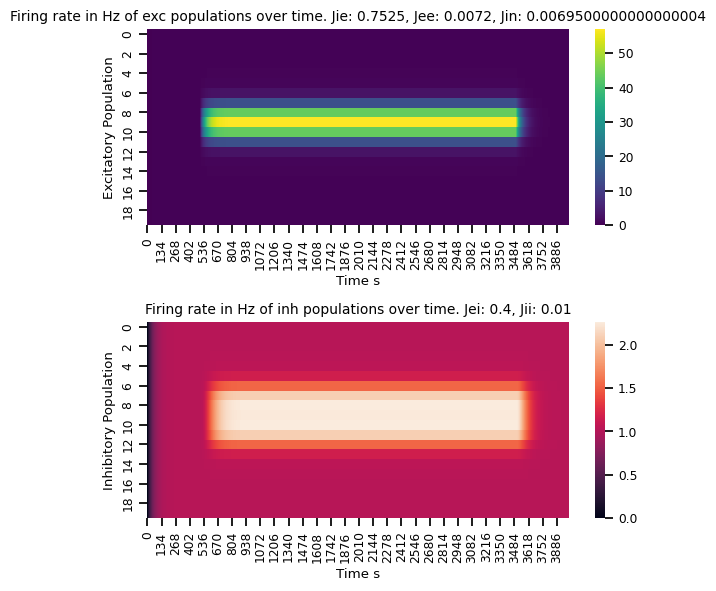

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 1.0  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.01 Jie: 1.0  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


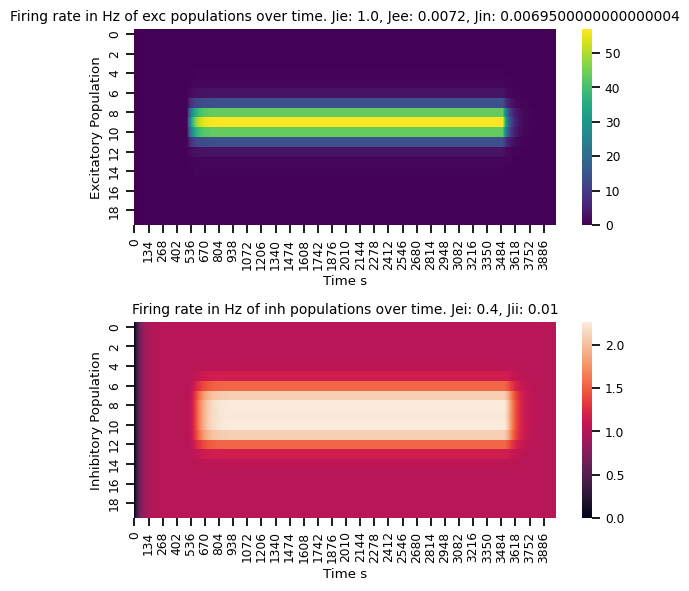

In [36]:
R_Jsetting("Jie")

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.001  Jin: 0.006
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.006  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


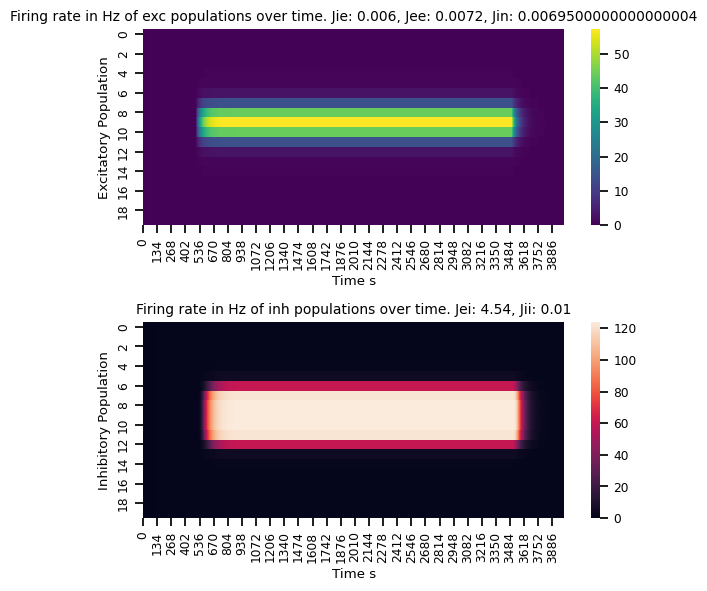

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.001  Jin: 0.006500000000000001
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.006500000000000001  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


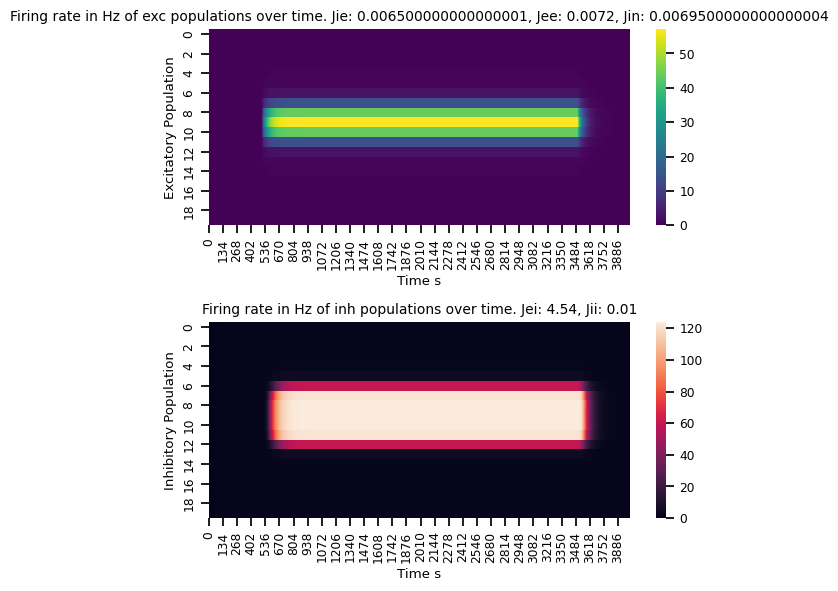

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.001  Jin: 0.007
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.007  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


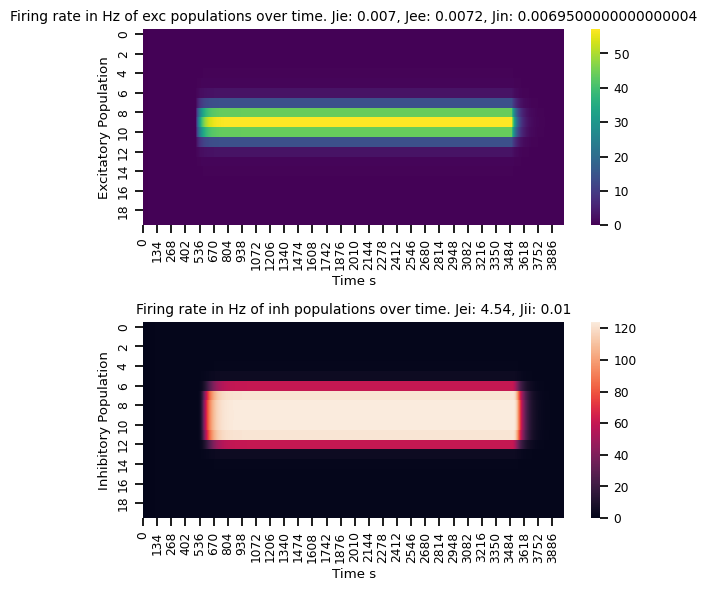

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.001  Jin: 0.0075
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.0075  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


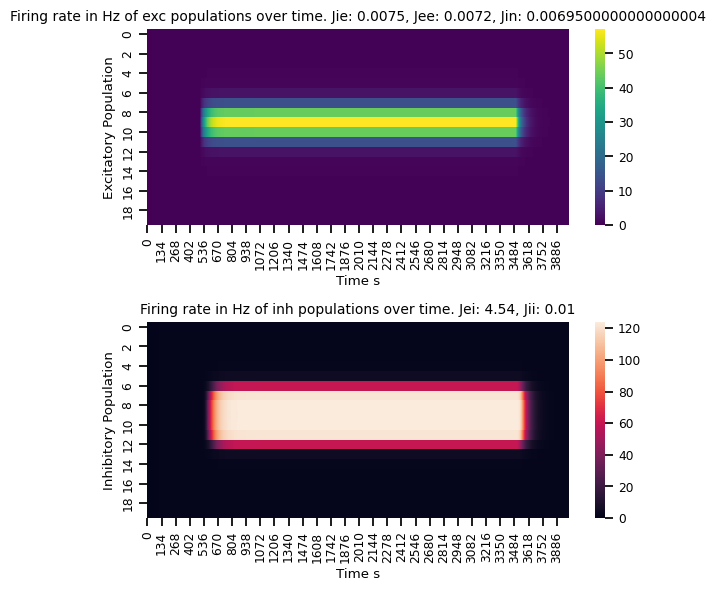

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.001  Jin: 0.008
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000
sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 4.54
Jii 0.01 Jie: 0.008  Jin: 0.0069500000000000004
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


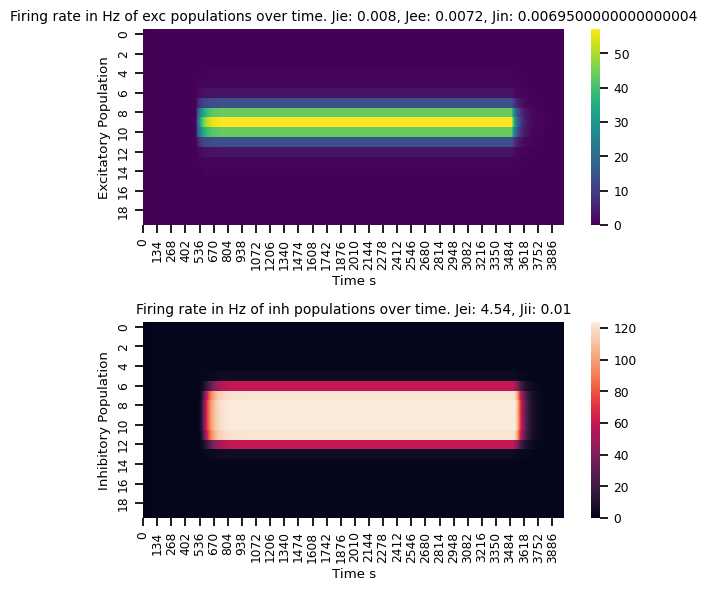

In [37]:
R_Jsetting("Jin")

Best parameters so far:

sIN 0.06 sout 3.0 sEI 0.2
Jee: 0.0072   Jei: 0.4
Jii 0.0001 Jie: 0.001  Jin: 0.0069500000000000004